In [1]:
#!/usr/bin/env python
import tensorflow as tf
import os
import os.path
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

/home/lk/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lk/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lk/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lk/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: P

In [ ]:
#seed = 69
#np.random.seed = seed

#IMG_WIDTH    = 384 #128
#IMG_HEIGHT   = 384 #128
#IMG_CHANNELS = 1   #3

#TRAIN_PATH = 'data/train/'
#TEST_PATH  = 'data/test/'

#train_ids = next(os.walk(TRAIN_PATH))[1]
#test_ids  = next(os.walk(TEST_PATH))[1]

#X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [22]:
# https://keras.io/examples/vision/oxford_pets_image_segmentation/
# https://imgaug.readthedocs.io/en/latest/source/examples_segmentation_maps.html
# https://www.tensorflow.org/tutorials/images/segmentation
# https://towardsdatascience.com/generating-image-segmentation-masks-the-easy-way-dd4d3656dbd1
# https://www.pyimagesearch.com/2020/09/28/image-segmentation-with-mask-r-cnn-grabcut-and-opencv/
# https://albumentations.ai/docs/getting_started/mask_augmentation/
input_dir = "/home/lk/Public/ML4STS/Classification/data/train/images/"
target_dir = "/home/lk/Public/ML4STS/Classification/data/train/masks/"
img_size = (384, 384)
num_classes = 8
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path) 

Number of samples: 512
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3160.png | /home/lk/Public/ML4STS/Classification/data/train/masks/inline_3160.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3161.png | /home/lk/Public/ML4STS/Classification/data/train/masks/inline_3161.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3162.png | /home/lk/Public/ML4STS/Classification/data/train/masks/inline_3162.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3163.png | /home/lk/Public/ML4STS/Classification/data/train/masks/inline_3163.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3164.png | /home/lk/Public/ML4STS/Classification/data/train/masks/inline_3164.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3165.png | /home/lk/Public/ML4STS/Classification/data/train/masks/inline_3165.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3166.png | /home/lk/Public/ML4STS/Classifica

In [27]:
seed = 69
np.random.seed = seed

IMG_WIDTH    = 384 #128
IMG_HEIGHT   = 384 #128
IMG_CHANNELS = 3

X_train = np.zeros((len(input_img_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(input_img_paths), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)  

print(X_train.shape)
print(Y_train.shape)

(512, 384, 384, 3)
(512, 384, 384, 1)


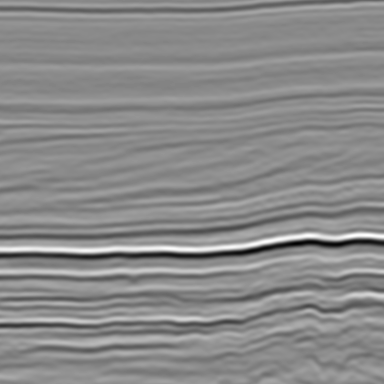

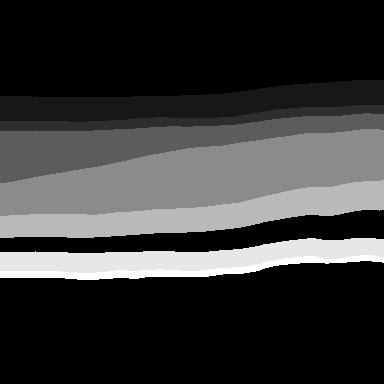

In [24]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[100]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[100]))
display(img)

In [28]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y


In [30]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [31]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

NameError: name 'model' is not defined

In [12]:
# https://www.newbedev.com/python/howto/how-to-iterate-over-files-in-a-given-directory/
from pathlib import Path

print('Resizing training images and masks')

path_images = Path('/home/lk/Public/ML4STS/Classification/data/train/images').glob('**/*.png')
n = 0
for path in path_images:
    # because path is object not string
    path_in_str = str(path)
    # Do thing with the path
    print(path_in_str)
    n += 1
    img = imread(path_in_str)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
path_masks = Path('/home/lk/Public/ML4STS/Classification/data/train/masks').glob('**/*.png')
n = 0    
for path in path_masks:
    path_in_str = str(path)
    print(path_in_str)
    n += 1
    mask_ = imread(path_in_str)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                  preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)

    Y_train[n] = mask

print('Train Done!')

Resizing training images and masks
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3212.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3576.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3221.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3463.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3601.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3265.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3349.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3333.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3471.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3428.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3632.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3455.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3553.png
/home/lk/Public/ML4STS/Classi

/home/lk/Public/ML4STS/Classification/data/train/images/inline_3192.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3648.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3656.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3636.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3239.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3278.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3625.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3228.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3476.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3353.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3515.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3610.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3456.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3

/home/lk/Public/ML4STS/Classification/data/train/images/inline_3410.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3294.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3629.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3352.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3497.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3559.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3229.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3186.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3513.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3399.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3351.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3237.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3526.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3

/home/lk/Public/ML4STS/Classification/data/train/images/inline_3438.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3446.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3671.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3598.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3381.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3631.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3554.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3220.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3173.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3599.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3296.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3390.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3537.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3

/home/lk/Public/ML4STS/Classification/data/train/images/inline_3533.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3203.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3540.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3658.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3581.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3424.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3555.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3204.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3374.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3462.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3646.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3500.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3335.png
/home/lk/Public/ML4STS/Classification/data/train/images/inline_3

ValueError: operands could not be broadcast together with shapes (384,384,1) (384,384,4,1) 

In [ ]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img # Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y_train[n] = mask

print('Train Done!')

# test images
#X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#sizes_test = []
#print('Resizing test images')
#for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#    path = TEST_PATH + id_
#    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#    sizes_test.append([img.shape[0], img.shape[1]])
#    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#    X_test[n] = img
#
#print('Test Done!')

TypeError: Invalid shape (384, 384, 1) for image data

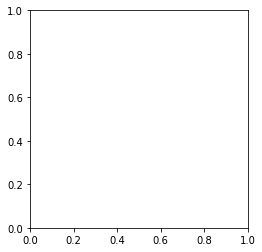

In [13]:
#image_x = random.randint(0, len(train_ids))
image_x = random.randint(0, 3671)
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [ ]:
# Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

################################
# Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)
####################################

idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()